# Analyse des occupations   

In [3]:
### Librairies externes à ajouter le cas échéant à l'environnement Python actif

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import networkx as nx

### Librairies déjà installées avec Python

import pprint
import csv
import sys

from importlib import reload



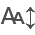

In [4]:
### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)

In [5]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## Importer les donnée à analyser

In [6]:
## define SPARQL enpoint
endpoint = "https://ag1gha303ygjmx4r.allegrograph.cloud/repositories/nobel-laureats"

In [7]:
### Get and count persons fields

query = """PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?field ?fieldLabel (COUNT(*) as ?n)
WHERE {
    GRAPH <https://github.com/VericaD/nobel_laureates_pc/blob/main/graph/wikidata-imported-data.md>
        {?item wdt:P101 ?field.
        ?field rdfs:label ?occupLabel
        BIND(LCASE(?occupLabel) as ?fieldLabel)    
          }
}
GROUP BY ?field ?fieldLabel 
ORDER BY DESC(?n)
#LIMIT 30
"""

In [8]:
### Execute the query using the local custom fonctions
qr = spqf.get_json_sparql_result(endpoint,query)

In [9]:
### Count and inspect the available fields
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

381


[['http://www.wikidata.org/entity/Q413', 'physics', '165'],
 ['http://www.wikidata.org/entity/Q7094', 'biochemistry', '113'],
 ['http://www.wikidata.org/entity/Q2329', 'chemistry', '85']]

In [10]:
### Transform the results into a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'effectif']
df_r['effectif'] = df_r.effectif.apply(lambda x : int(x))
df_r.head()

,uri,label,effectif
0,http://www.wikidata.org/entity/Q413,physics,165
1,http://www.wikidata.org/entity/Q7094,biochemistry,113
2,http://www.wikidata.org/entity/Q2329,chemistry,85
3,http://www.wikidata.org/entity/Q521,physiology,32
4,http://www.wikidata.org/entity/Q11351,organic chemistry,31


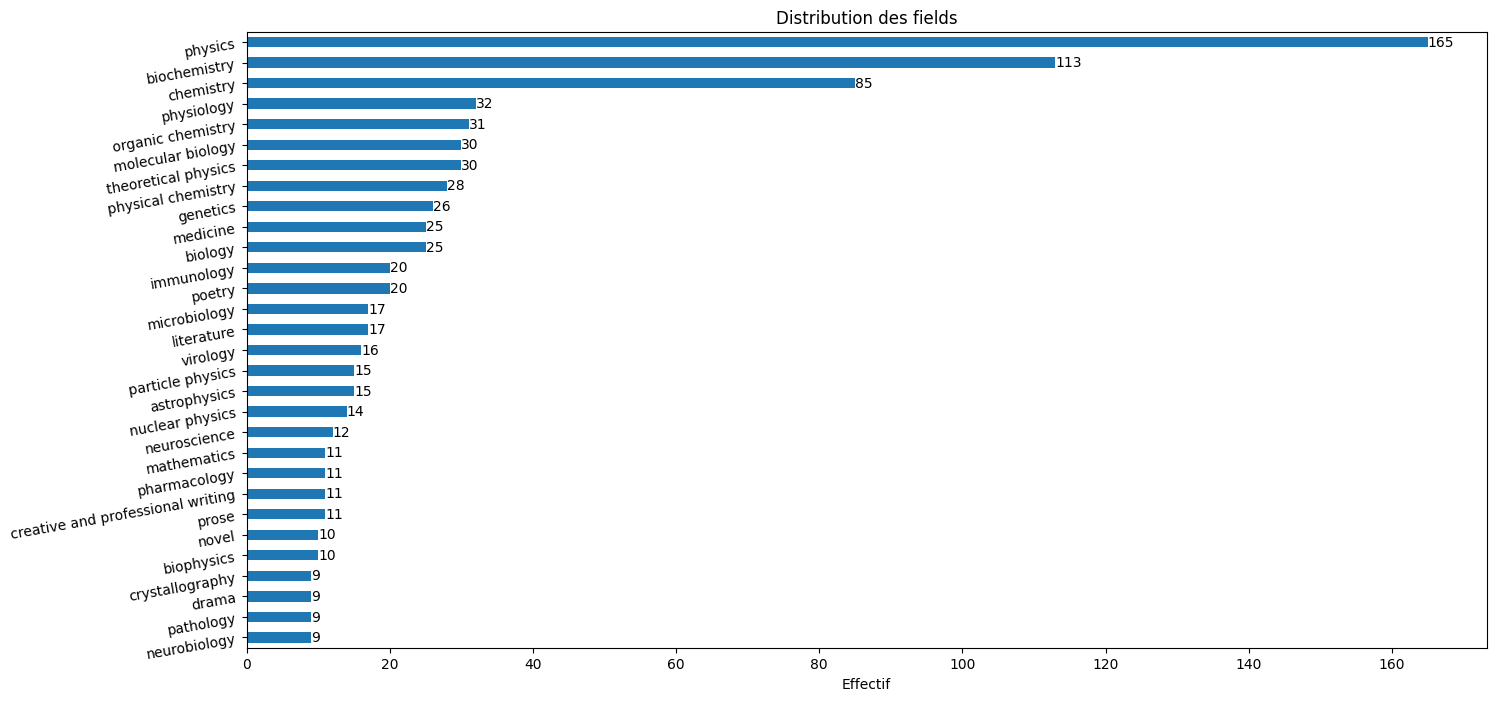

In [11]:
### Bar chart showing distribution by 'field': 
# 30 most frequent fields
ax = df_r['effectif'].head(30).sort_values(ascending=True)\
    .plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(df_r.head(30).label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des fields')
plt.show()

In [12]:
l= len(df_r[df_r['effectif'] == 1])
print(l)

251


In [13]:
l= len(df_r[df_r['effectif'] < 10])
print(l)

355


**Comment**: An extreme difference in distribution can be observed: three occupational categories are three to five times larger than the others.

There are 251 occupations with only one person and 355 with less than 10 persons, for a total of 381 different occupations.

### Graphically represent the frequency distribution

There is a wide dispersion of values and a predominant position for activities involving 10 or fewer people

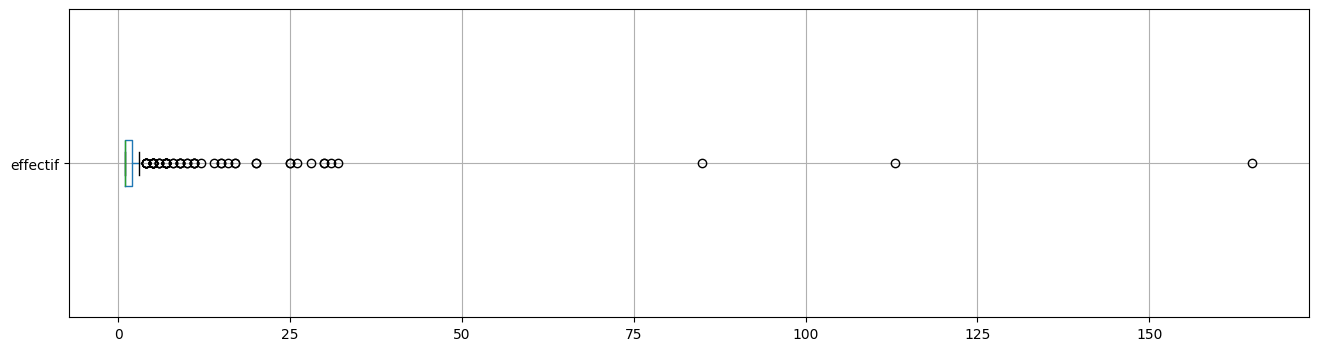

In [14]:
### Distribution des effectifs par field
ax = df_r.boxplot(column=['effectif'], vert=False, figsize=(16,4))

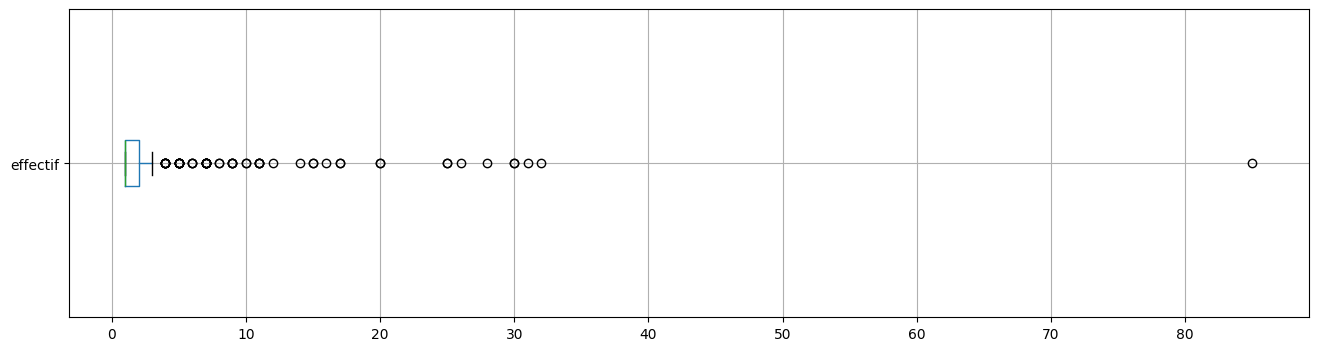

In [15]:
### Distribution des effectifs par occupation
ax = df_r[df_r.effectif<100].boxplot(column=['effectif'], vert=False, figsize=(16,4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

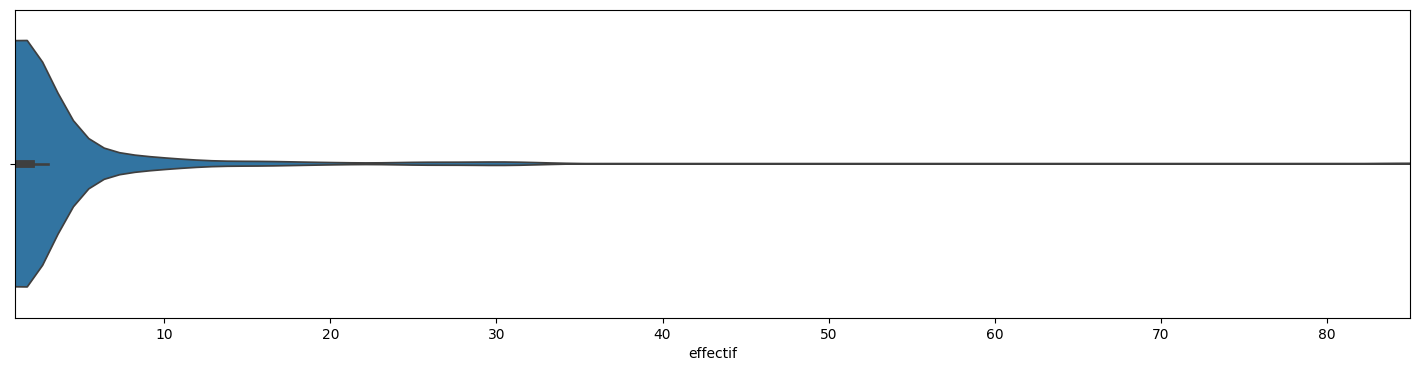

In [16]:
### Represent the density (the total surface has frequency = 1)
# https://seaborn.pydata.org/generated/seaborn.violinplot.html

plt.figure(figsize=(18,4))
d = df_r[df_r.effectif<100].effectif

ax = sns.violinplot(x = d)


### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=min(d), right=max(d))
plt.show()

### Group by frequency range

In [17]:
### Set the thresholds

ls = [1, 5, 10, 20, 50, 100, 200, 300]
print(ls)

[1, 5, 10, 20, 50, 100, 200, 300]


In [18]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_r['seuils'] = pd.cut(df_r['effectif'], ls, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_r['seuils'] = df_r['seuils'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_r.head(3)

,uri,label,effectif,seuils
0,http://www.wikidata.org/entity/Q413,physics,165,100-199
1,http://www.wikidata.org/entity/Q7094,biochemistry,113,100-199
2,http://www.wikidata.org/entity/Q2329,chemistry,85,50-99


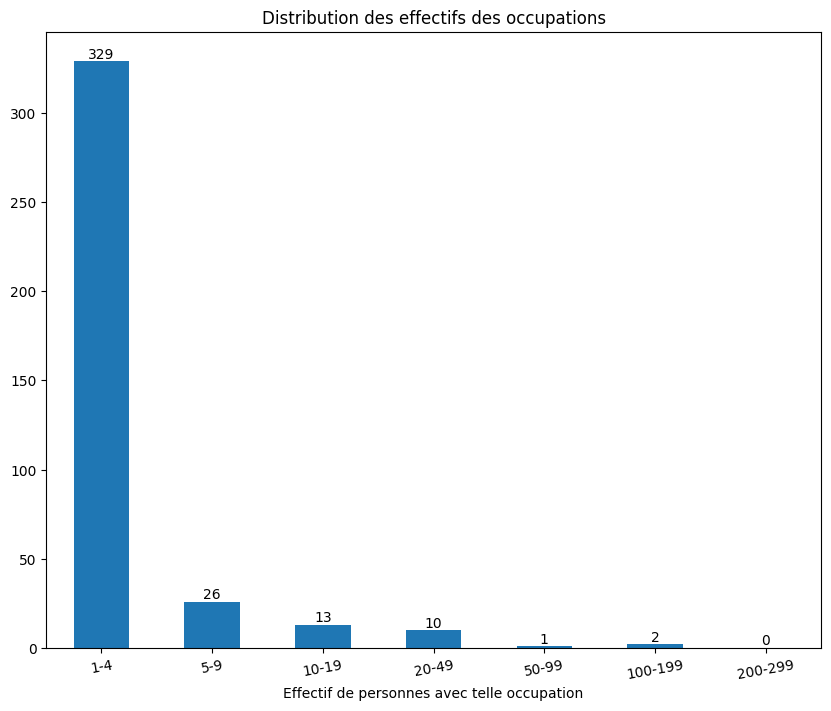

In [19]:
# Plot the grouped distribution

ax = df_r.groupby(by='seuils', observed=False).size()\
    .plot(kind='bar',rot=10, fontsize=10, figsize=(10,8))
ax.bar_label(ax.containers[-1], fontsize=10)
plt.xlabel('Effectif de personnes avec telle occupation')
plt.title('Distribution des effectifs des occupations')
plt.show()

### Inspect the values

In [20]:
print(df_r[df_r['effectif'] == 1].head(10).label)

130                  ribonuclease
131           molecular chemistry
132               electron optics
133    women's suffrage in sweden
134             travel literature
135              sulfonamide drug
136                         maser
137                chromatography
138               phosphorescence
139                  polarography
Name: label, dtype: object


In [21]:
print(df_r[df_r['effectif'] == 5].head(10).label)

44     developmental biology
45             radioactivity
46         superconductivity
47               translation
48    electrical engineering
49                 neurology
50              cell biology
51           neurophysiology
Name: label, dtype: object


In [22]:
print(df_r[df_r['effectif'] == 10].head(10).label)

24         novel
25    biophysics
Name: label, dtype: object


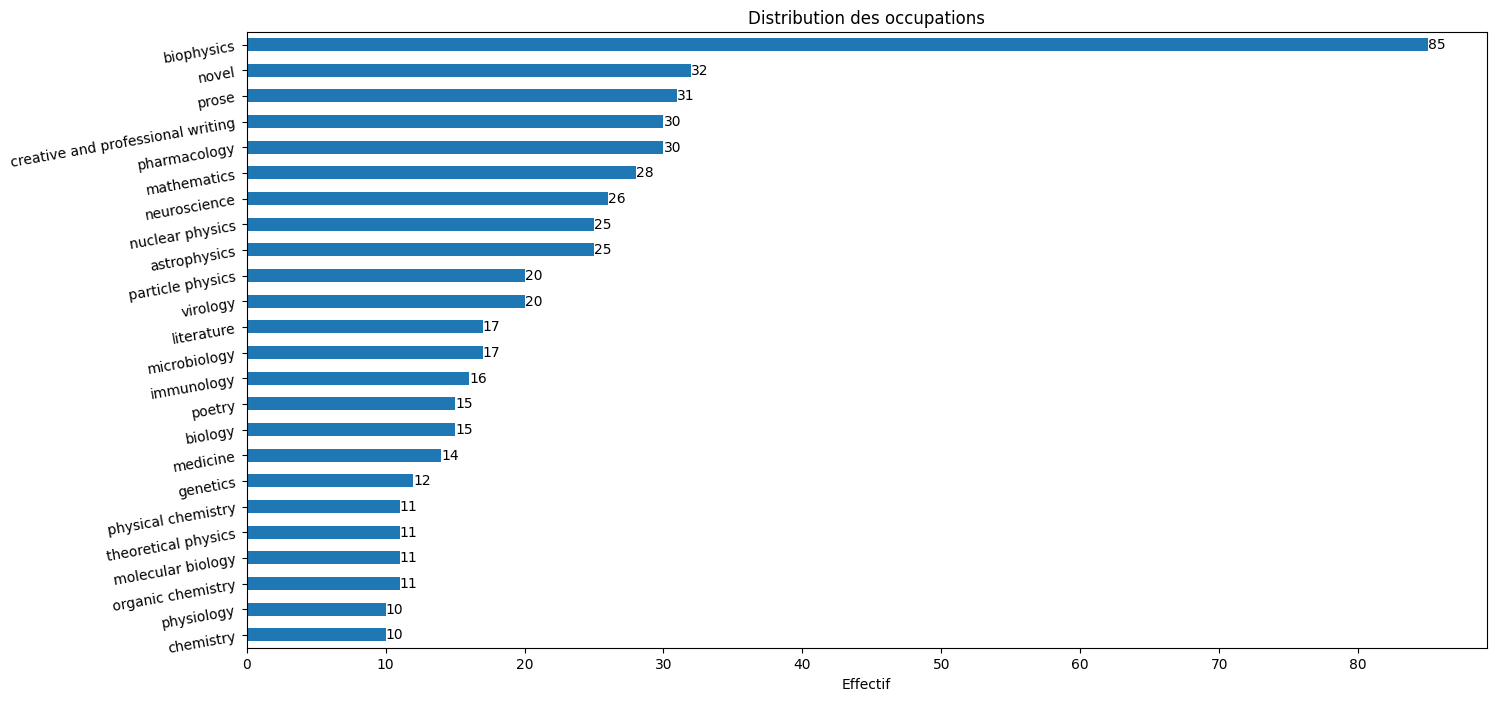

In [23]:
### Bar chart representing the distribution by ‘occupation’ 
# in a given frequency range

d = df_r[(df_r.effectif < 100)&(df_r.effectif > 9)].sort_values(by='effectif',ascending=True).head(40)
ax = d.effectif.plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(d.label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des occupations')
plt.show()

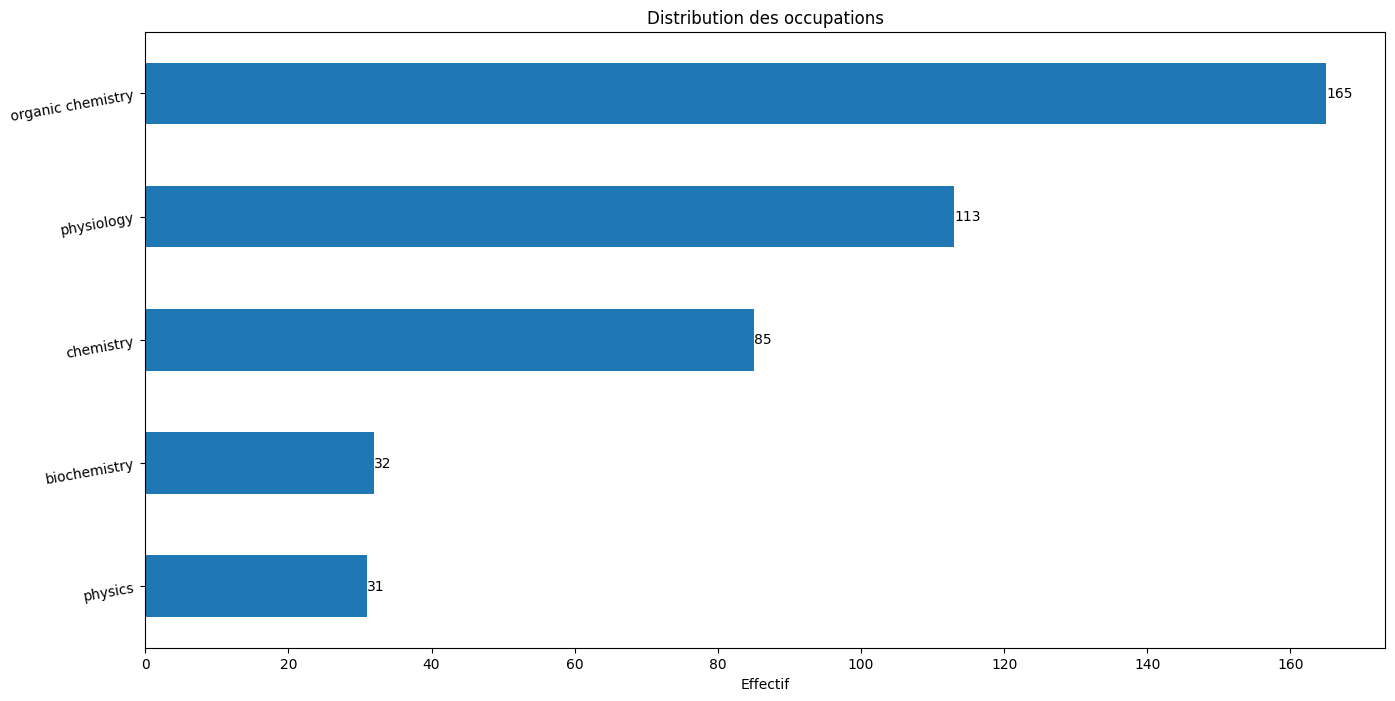

In [24]:
### Bar chart representing the distribution by ‘occupation’ 
# in a given frequency range

d = df_r[df_r.effectif > 30].sort_values(by='effectif',ascending=True) # > 100 , there are only 2 
ax = d.effectif.plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(d.label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des occupations')
plt.show()

**Comment**

,,,


## Explore the number of fields per person

In [25]:
### Basic query regarding persons' fields

query = """PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?item ?itemLabel (COUNT(*) as ?n)
WHERE {
    GRAPH <https://github.com/VericaD/nobel_laureates_pc/blob/main/graph/wikidata-imported-data.md>
        {?item wdt:P101 ?field.
        OPTIONAL {?item rdfs:label ?itemLabel}    
          }
}
GROUP BY ?item ?itemLabel
ORDER BY DESC(?n)
#LIMIT 500
"""

In [26]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [27]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

714


[['http://www.wikidata.org/entity/Q34670', 'Albert Camus', '13'],
 ['http://www.wikidata.org/entity/Q214851', 'Charles Richet', '12'],
 ['http://www.wikidata.org/entity/Q33760', 'Bertrand Russell', '12']]

In [28]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'effectif']
df_r['effectif'] = df_r.effectif.apply(lambda x : int(x))
df_r.head()

,uri,label,effectif
0,http://www.wikidata.org/entity/Q34670,Albert Camus,13
1,http://www.wikidata.org/entity/Q214851,Charles Richet,12
2,http://www.wikidata.org/entity/Q33760,Bertrand Russell,12
3,http://www.wikidata.org/entity/Q392,Bob Dylan,10
4,http://www.wikidata.org/entity/Q8753,Enrico Fermi,9


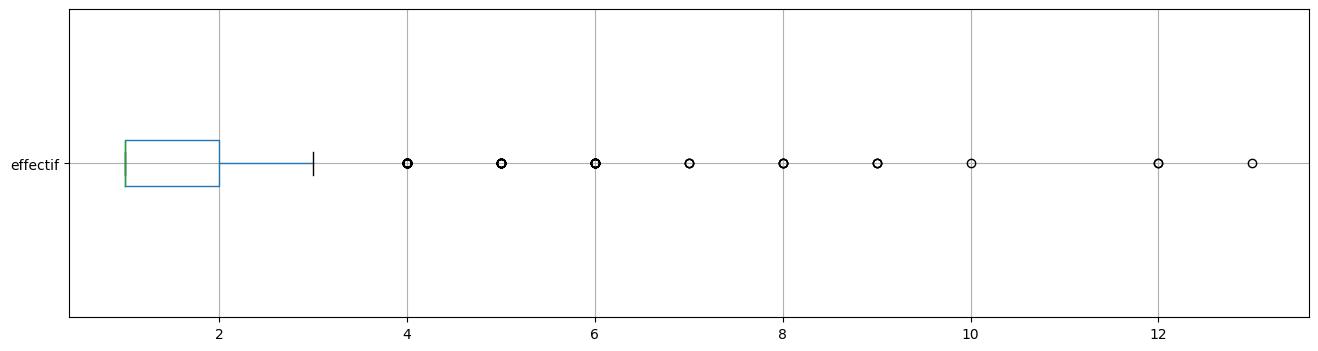

In [29]:
### Distribution of frequencies per person
ax = df_r.boxplot(column=['effectif'], vert=False, figsize=(16,4))

## this fuction avoids ticks with floats instead of integers
#  on the x axis
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

**Comment**

Most persons have between 6 and 8 occupations, with some outliers

7


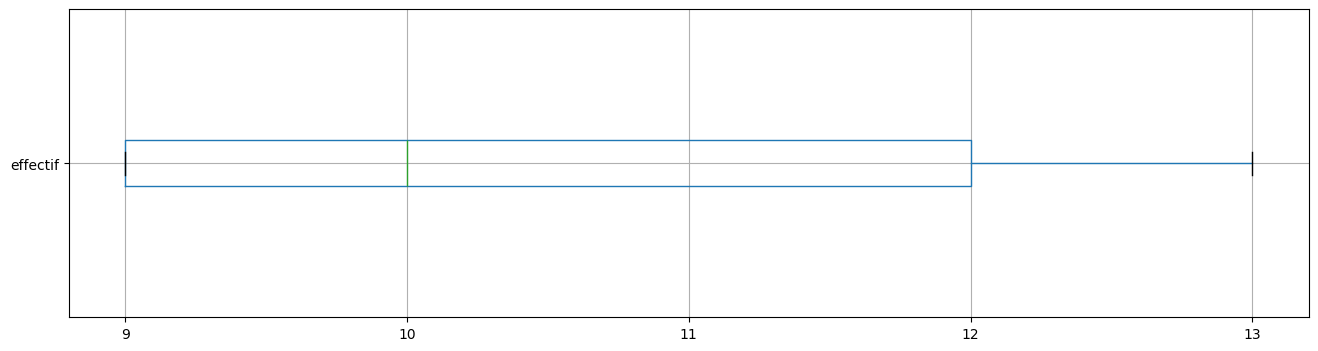

In [30]:
### Distribution des effectifs par occupation

d = df_r[df_r.effectif > 8]
print(len(d))

ax = d.boxplot(column=['effectif'], vert=False, figsize=(16,4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [31]:
### Cf. the profiles of these persons in Wikidata
pprint.pprint(d.tail())

                                      uri             label  effectif
2   http://www.wikidata.org/entity/Q33760  Bertrand Russell        12
3     http://www.wikidata.org/entity/Q392         Bob Dylan        10
4    http://www.wikidata.org/entity/Q8753      Enrico Fermi         9
5     http://www.wikidata.org/entity/Q862    Joseph Brodsky         9
6  http://www.wikidata.org/entity/Q192688      Ivar Giaever         9


## Parent occupations

We can try to use the taxonomy of occupations to select relevant occupations.

We therefore go back to the [Import sparqlbook](../../sparqlbooks/wdt_import_occupations.sparqlbook)

In [36]:
query = """
## 

### Simplified query

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>

SELECT DISTINCT 
?occupation ?occupationLabel ?parentField ?parentFieldLabel
?n
          #?parentKnowledgeClassification ?parentKnowledgeClassificationLabel 
          # (SUM(?n) as ?sn)
WHERE {
    GRAPH <https://github.com/VericaD/nobel_laureates_pc/blob/main/graph/wikidata-imported-data.md>
        {
          SELECT ?occupation ?occupationLabel
          ?parentOccupation (COUNT(*) as ?n)
        
        WHERE
        {
          ?s a wd:Q5;  
              wdt:P106 ?occupation.
          ?occupation rdfs:label ?occupationLabel.
          ?occupation  wdt:P279  ?parentOccupation.
          }  
        GROUP BY ?occupation ?occupationLabel
          ?parentOccupation
        }

        SERVICE <https://query.wikidata.org/sparql>
          {
              # field of parent occupation / instance of /  subclass of  
              ?parentOccupation wdt:P425 / wdt:P31 ?parentField.
              # ?parentField wdt:P279 ?parentKnowledgeClassification.


              #BIND (?occupation as ?occupationLabel)
              BIND (?parentFieldLabel as ?parentFieldLabel)
              # BIND (?parentKnowledgeClassificationLabel as ?parentKnowledgeClassificationLabel)
              SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } 
          }

}
# GROUP BY ?occupation ?occupationLabel ?parentField ?parentFieldLabel
          # ?parentKnowledgeClassification ?parentKnowledgeClassificationLabel 
ORDER BY DESC(?n)
"""

In [37]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [38]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

884


[['http://www.wikidata.org/entity/Q1622272',
  'university teacher',
  'http://www.wikidata.org/entity/Q2465832',
  'branch of science',
  '475'],
 ['http://www.wikidata.org/entity/Q1622272',
  'university teacher',
  'http://www.wikidata.org/entity/Q26256810',
  'topic',
  '475'],
 ['http://www.wikidata.org/entity/Q1622272',
  'university teacher',
  'http://www.wikidata.org/entity/Q130303173',
  'service type',
  '475']]

In [39]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uriOccupation', 'labelOccupation', 'uriDomaine', 'labelDomain', 'size']
# df_r['size'] = df_r.size.apply(lambda x : int(x))
df_r.head()

,uriOccupation,labelOccupation,uriDomaine,labelDomain,size
0,http://www.wikidata.org/entity/Q1622272,university teacher,http://www.wikidata.org/entity/Q2465832,branch of science,475
1,http://www.wikidata.org/entity/Q1622272,university teacher,http://www.wikidata.org/entity/Q26256810,topic,475
2,http://www.wikidata.org/entity/Q1622272,university teacher,http://www.wikidata.org/entity/Q130303173,service type,475
3,http://www.wikidata.org/entity/Q1622272,university teacher,http://www.wikidata.org/entity/Q11862829,academic discipline,475
4,http://www.wikidata.org/entity/Q1622272,university teacher,http://www.wikidata.org/entity/Q12737077,occupation,475


In [40]:

## [gb_oc['size'] > 4 ]

show(df_r,  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", # columnDefs=[{"className": "dt-left", "targets": "_all"}],
     search={"regex": True, "caseInsensitive": True},
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading ITables v2.3.0 from the init_notebook_mode cell... (need help?)


In [41]:
query = """
### Occupation classifications

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?birthYear ?o ?oLabel ?oP ?oPLabel
WHERE {
    GRAPH <https://github.com/VericaD/nobel_laureates_pc/blob/main/graph/wikidata-imported-data.md>
        {?item a wd:Q5;
            wdt:P569 ?birthYear;
            wdt:P106 ?o.
        ?o a wd:Q12737077;
            wdt:P279 ?o1.
        OPTIONAL {?o rdfs:label ?oLabel}    
        OPTIONAL {?oP rdfs:label ?oPLabel}    
          }
}
ORDER BY ?s
"""

In [42]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

KeyboardInterrupt: 

In [ ]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['year', 'oc_uri', 'oc_label', 'op_uri', 'op_label']
df_r['year'] = df_r.year.apply(lambda x : int(x))
df_r.head()

,year,oc_uri,oc_label,op_uri,op_label
0,1923,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q124637774,physical scientist
1,1908,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q124637774,physical scientist
2,1882,http://www.wikidata.org/entity/Q3126128,geneticist,http://www.wikidata.org/entity/Q864503,biologist
3,1937,http://www.wikidata.org/entity/Q1650915,researcher,http://www.wikidata.org/entity/Q66666685,academic professional
4,1937,http://www.wikidata.org/entity/Q1650915,researcher,http://www.wikidata.org/entity/Q15980158,non-fiction writer


### Codage par période de cinquante ans

In [ ]:
### Créer une liste d'années pour séparer en périodes de 50 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
d = list(range(1751, 2001, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1851, 1876, 1901, 1926, 1951] 8


In [ ]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_r['per_25'] = pd.cut(df_r['year'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_r['per_25'] = df_r['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_r.head(3)

,year,oc_uri,oc_label,op_uri,op_label,per_25
0,1923,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q124637774,physical scientist,1901-1925
1,1908,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q124637774,physical scientist,1901-1925
2,1882,http://www.wikidata.org/entity/Q3126128,geneticist,http://www.wikidata.org/entity/Q864503,biologist,1876-1900


In [ ]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25').size()
print(naissances_per)

per_25
1751-1775     254
1776-1800     326
1801-1825     532
1826-1850     809
1851-1875    1312
1876-1900    1916
1901-1925    4210
1926-1950    8132
dtype: int64


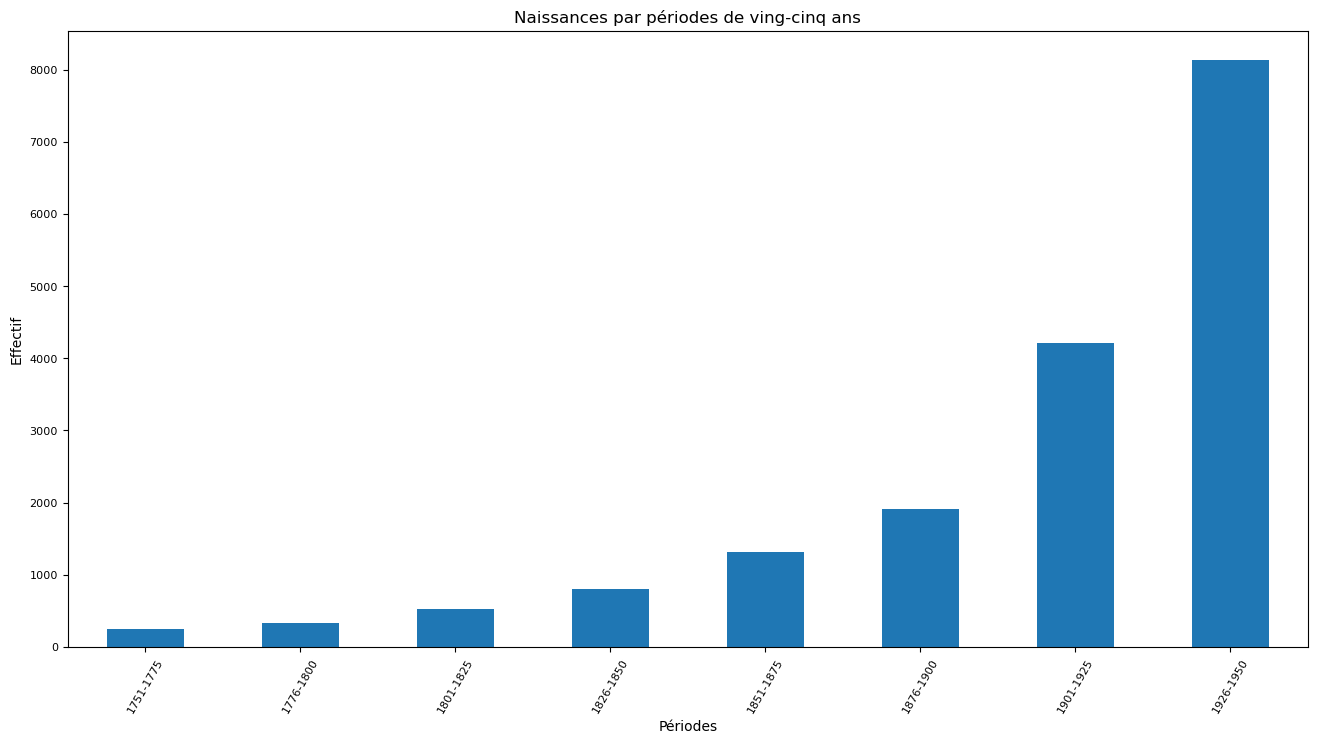

In [ ]:
### Diagramme à barres représentant la distribution par 'génération'
ax = df_p.groupby(by='per_25').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de ving-cinq ans')
plt.show()

In [ ]:
### distribution des naissances par périodes de 25 ans
gb_oc = df_r.groupby(by=['oc_label','op_label'], observed=False, as_index=False).size()
print(len(gb_oc))
gb_oc.head()

1462


,oc_label,op_label,size
0,Aliyah Bet activist,political activist,2
1,Anglican priest,Anglican clergyman,4
2,Anglican priest,Western priest,4
3,Bible translator,biblical scholar,2
4,Bible translator,translator,2


In [ ]:

## [gb_oc['size'] > 4 ]

show(gb_oc.sort_values(by='size', ascending=False),  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading... (need help?)
